

![](https://images.aicrowd.com/raw_images/challenges/banner_file/902/af8a219e0f122fa841e1.jpg)


# 0. Installing aircrowd-cli and downloading Dataset


In [ ]:
!pip install aicrowd-cli
%load_ext aicrowd.magic

In [ ]:
%aicrowd login

Please login here: https://api.aicrowd.com/auth/NdO9b6vBtOqzIO3pPwPuUMrl4yK0QS4LBJoayEfIMvA
API Key valid
Saved API Key successfully!


In [ ]:
!rm -rf data
!mkdir data
%aicrowd ds dl -c object-detection -o data

test.zip:   0%|          | 0.00/49.4M [00:00<?, ?B/s]

train.json:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

train.zip:   0%|          | 0.00/146M [00:00<?, ?B/s]

In [ ]:
!unzip data/train.zip -d data/train > /dev/null
!unzip data/test.zip -d data/test > /dev/null

#1. Downloading & Importing Libraries

In this puzzle, we will be using [detectron2](https://github.com/facebookresearch/detectron2) to train and generate our predictions. Detectron2 is a library to Facebookresearch mainly used for object detection, semantic segmentation and other similar computer vision tasks   

In [ ]:
!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/fvcore.git
import torch, torchvision
torch.__version__

In [ ]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

In [ ]:
# Detection
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from glob import glob
from PIL import Image
from natsort import natsorted
from tqdm.notebook import tqdm
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
import pandas as pd
import json

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultTrainer
from detectron2.data.datasets import register_coco_instances
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Creating the dataset

Here, we create registering our training dataset that detectron2 will be using during training

In [ ]:
ann_dir = "./data"

f = open(os.path.join(ann_dir,'train.json'),'r')
data = json.loads(f.read())

for i in data['annotations']:
    i['iscrowd'] = 0

ant = pd.DataFrame(data['annotations'])

splits = train_test_split(ant['image_id'].unique(), test_size=0.25, random_state=201)
print(len(splits[0]),len(splits[1]))

train_annotations = []
val_annotations = []
for i in data['annotations']:
    if i['image_id'] in splits[0]:
        train_annotations.append(i)
    elif i['image_id'] in splits[1]:
        val_annotations.append(i)
        
print(len(train_annotations),len(val_annotations))

train_ids = [i['id'] for i in train_annotations]
val_ids = [i['id'] for i in val_annotations]

train_images = []
val_images = []

for i in data['images']:
    img_id = int(i['file_name'].split(".")[0])
    if img_id in splits[0]:
        train_images.append(i)
    elif img_id in splits[1]:
        val_images.append(i)
        
train_data = data.copy()
train_data['annotations'] = train_annotations
train_data['images'] = train_images

val_data = data.copy()
val_data['annotations'] = val_annotations
val_data['images'] = val_images


with open('train_data.json', 'w') as f:
    json.dump(train_data, f)
    
with open('val_data.json', 'w') as f:
    json.dump(val_data, f)

2250 750
6580 2188


In [ ]:
!mkdir dataset
!mkdir dataset/train
!mkdir dataset/val

In [ ]:
import shutil

s_dir = "./data/train"
d_dir = "dataset/train"

for fname in tqdm(train_data['images']):
    shutil.copy2(os.path.join(s_dir,fname['file_name']), os.path.join(d_dir,fname['file_name']))
    
s_dir = "./data/train"
d_dir = "dataset/val"

for fname in tqdm(val_data['images']):
    shutil.copy2(os.path.join(s_dir,fname['file_name']), os.path.join(d_dir,fname['file_name']))

  0%|          | 0/2249 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

In [ ]:
data_dir = "dataset"

register_coco_instances("train", {}, "train_data.json", os.path.join(data_dir, "train"))
register_coco_instances("val", {}, "val_data.json", os.path.join(data_dir, "val"))


# Visualizing the dataset

In [ ]:
vehicle_metadata = MetadataCatalog.get("train")
dataset_dicts = DatasetCatalog.get("train")

WARNING [09/19 06:31:19 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

WARNING [09/19 06:31:19 d2.data.datasets.coco]: train_data.json contains 6580 annotations, but only 4944 of them match to images in the file.
[09/19 06:31:19 d2.data.datasets.coco]: Loaded 2249 images in COCO format from train_data.json


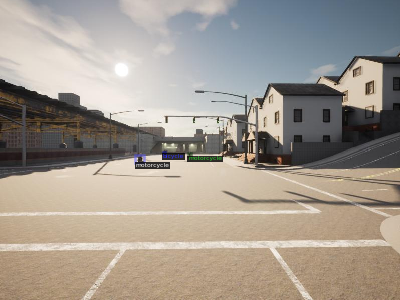

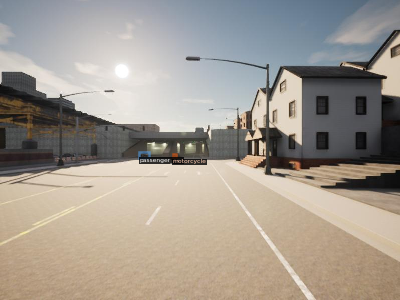

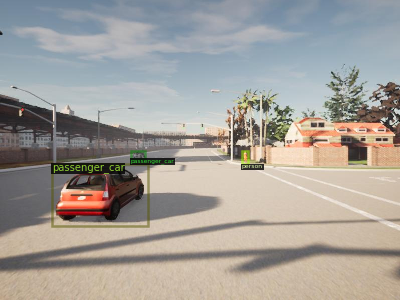

In [ ]:
import random

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=vehicle_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

# Creating the model

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("train",)
cfg.DATASETS.TEST = ('val',)

cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001


cfg.SOLVER.MAX_ITER = 8000
cfg.SOLVER.STEPS = []

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4
cfg.TEST.EVAL_PERIOD = 100

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)

# Training the model

In [ ]:
trainer.train()

# Predictions

Generating sample predictions, due to the evaluation criteria of this puzzle turns out that low threshold gives better LB score.

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

# Setting up threshold to filter out some low score predictions
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1

predictor = DefaultPredictor(cfg)

In [ ]:
from detectron2.utils.visualizer import ColorMode

# Showing some predictions
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=vehicle_metadata, 
                   scale=0.8, 
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

# Generating Predictions

In this section, we will be generating the prediction of test dataset for submission

In [ ]:
test_images_list = natsorted(glob("data/test/*"))
test_images_list[0]

'data/test/0.jpg'

In [ ]:
# Generating the predictions

pred = []

# Doing though each image
for file_path in tqdm(test_images_list):

  # Reading the image
  img = cv2.imread(file_path)

  # Generating the predictions
  outputs = predictor(img)


  image_path, image_file_name = os.path.split(file_path)
  
  # Getting the image_id of the predictions 
  # ( The image_id in the predictions is the file_id  + 1 )
  image_id = int(image_file_name.split(".")[0])+1


  # Adding the predictions
  for n, boxes in enumerate(outputs['instances'].pred_boxes.tensor.cpu().numpy().tolist()):

    # Converting thr bounding boxes from (x1, y1, x2, y2) to (x, y, w, h)
    preprocessed_box = [boxes[0], boxes[1], abs(boxes[0] - boxes[2]), abs(boxes[1] - boxes[3])]

    pred.append({
        "image_id": image_id,
        "category_id": outputs['instances'].pred_classes[n].cpu().numpy().tolist(),
        "bbox": preprocessed_box,
        "score":outputs['instances'].scores[n].cpu().numpy().tolist()
    })

100%|██████████| 1000/1000 [05:46<00:00,  2.89it/s]


In [ ]:
# Saving the predictions
!rm -rf assets
!mkdir assets

with open('assets/predictions.json', 'w') as f:
    json.dump(pred, f)

# Uploading the Results 

In [ ]:
%aicrowd notebook submit -c object-detection -a assets --no-verify

/usr/local/lib/python3.7/dist-packages/aicrowd/notebook/helpers.py:361: UserWarning: `%aicrowd` magic command can be used to save the notebook inside jupyter notebook/jupyterLab environment and also to get the notebook directly from the frontend without mounting the drive in colab environment. You can use magic command to skip mounting the drive and submit using the code below:
 %load_ext aicrowd.magic
%aicrowd notebook submit -c object-detection -a assets --no-verify
  warnings.warn(description + code)
Mounting Google Drive 💾
Your Google Drive will be mounted to access the colab notebook
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww